Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


In [4]:
# Good beta value to start, as referenced by ritchieng.com
beta = 0.01
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

**Regularisation for Logistic Model :  Better to no regularisation : 88.8% @1m2sec  vs 82.1% @58sec**



In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  # loss function without regularisation
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # Loss function with regularisation
  regularisation_term = tf.nn.l2_loss(weights)
  #loss = tf.reduce_mean(
  #  tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta * regularisation_term
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta * regularisation_term
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
print('Simple Logistic REgression with Regularisation initialisation complete1')

Simple Logistic REgression with Regularisation initialisation complete1


Run NOW!!

In [6]:
import datetime
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

start_run = datetime.datetime.now()
with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  #tf.global_variables_initializer().run() ## using old tensorflow hence switching to old variable intialisation approach 
  tf.initialize_all_variables().run()  
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
print('Simple Logit regression with tensor graph run time ', datetime.datetime.now() - start_run)

Initialized
Loss at step 0: 47.543068
Training accuracy: 9.1%
Validation accuracy: 12.0%
Loss at step 100: 11.430303
Training accuracy: 74.1%
Validation accuracy: 71.8%
Loss at step 200: 4.330813
Training accuracy: 79.4%
Validation accuracy: 76.7%
Loss at step 300: 1.927941
Training accuracy: 82.7%
Validation accuracy: 79.6%
Loss at step 400: 1.111113
Training accuracy: 84.2%
Validation accuracy: 81.1%
Loss at step 500: 0.830003
Training accuracy: 84.8%
Validation accuracy: 81.8%
Loss at step 600: 0.732112
Training accuracy: 85.0%
Validation accuracy: 82.1%
Loss at step 700: 0.697701
Training accuracy: 85.0%
Validation accuracy: 82.2%
Loss at step 800: 0.685507
Training accuracy: 84.9%
Validation accuracy: 82.2%
Test accuracy: 88.9%
Simple Logit regression with tensor graph run time  0:00:56.670356


** Regularisation for SGD  Model  : Better  **     
-----------------------------------------------
** Regularised SGD vs SGD ::  88.6%@22s vs 86.9% @9s   **                 
** Regularised SGD vs GD  ::  88.6%@22s vs 88.8% @1m2sec **                


In [7]:
image_size = 28
num_labels = 10

In [8]:
def init_SGD(batch_size = 128):
    graph = tf.Graph()
    with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

      # Variables.
      weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
      biases = tf.Variable(tf.zeros([num_labels]))

      # Training computation.
      logits = tf.matmul(tf_train_dataset, weights) + biases
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
      test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    print('SGD Initialisation Complete')

batch_size = 128
init_SGD(batch_size = batch_size)


SGD Initialisation Complete


Run NOW !!!

In [9]:
def run_SGD(num_steps = 3001, limit_train_size_to = ''):
    if limit_train_size_to == '':
        # consider all train data
        limit_train_size_to = train_dataset.shape[0]
    train_dataset_limited_to = train_dataset[0:limit_train_size_to,:]
    train_labels_limited_to = train_labels[0:limit_train_size_to,:]
    accuracy_all = np.ndarray(shape = (1 + num_steps/500, 4), dtype = np.float32)
    
    start = datetime.datetime.now()
    with tf.Session(graph=graph) as session:
      #tf.global_variables_initializer().run()
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_limited_to.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_limited_to[offset:(offset + batch_size), :]
        batch_labels = train_labels_limited_to[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print('Training time taken with stochastic gradient and tensorflow', datetime.datetime.now()-start)

num_steps = 3001
run_SGD( num_steps = num_steps )
#run_SGD( num_steps = num_steps , limit_train_size_to = 512 )

Initialized


ValueError: Cannot feed value of shape (128, 784) for Tensor u'Const:0', which has shape '(10000, 784)'

** Regularised Deep Learning. Neural network - 1 hidden network ( 1024 hidden nodes)**
------------------------------------------------------------------------------
** Better and More Robust to SGD**                      
** Regularised NN vs NN : 90.3% @2.23m vs 89.3% @3.15m  **             


In [ ]:
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

def plot_accuracy(data):
    figure, axis = plt.subplots()
    axis.plot(data[:,0], data[:, 1:4] )
    axis.set_title('Accuracy across diff training size')
    axis.legend(('training batch data','validation data', 'test data'), loc = 'lower right')
    axis.set_xticks(data[:,0]) # set batch size on x -axis
    axis.set_xlabel('')
    axis.grid()
    plt.show()
    
    
import numpy as np
collect_accuracy_at_batch_interval_of = 500
print(datetime.datetime.now())

In [ ]:
def init_NN(batch_size,     num_hidden,    beta):
    graph = tf.Graph()
    with graph.as_default():

      # Input data. Unlike in earlier gradient descent, now we can take the whole data.
      # With gradient descent, we could not process all the input data and we had poor accuracy
      # For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

      # Variables.
      weights_for_hidden = tf.Variable(tf.truncated_normal([ image_size * image_size , num_hidden]))
      biases_for_hidden = tf.Variable(tf.zeros([num_hidden]))
      weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels]))
      biases = tf.Variable(tf.zeros([num_labels]))

      # Training computation.
      hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_for_hidden ) + biases_for_hidden)
      hidden_valid_dataset = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_for_hidden) + biases_for_hidden)
      hidden_test_dataset = tf.nn.relu(tf.matmul(tf_test_dataset, weights_for_hidden) + biases_for_hidden)
      #logits = tf.matmul(tf_train_dataset, weights) + biases
      logits = tf.matmul(hidden1, weights) + biases
      # loss without regularisation
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
      ## loss with regularisation
      regularisation_term = tf.nn.l2_loss(weights_for_hidden) + tf.nn.l2_loss(weights)
      loss = tf.reduce_mean( loss + beta * regularisation_term)

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)  

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_prediction = tf.nn.softmax(
        tf.matmul(hidden_valid_dataset, weights) + biases)
      test_prediction = tf.nn.softmax(tf.matmul(hidden_test_dataset, weights) + biases)
    print('Deep Neural Network with 1 Hidden layer with 1024 hidden nodes initialisation complete', datetime.datetime.now())


init_NN( batch_size = 128,     num_hidden = 1024,    beta = 0.01)

Run NOW !!

In [ ]:
print(train_dataset.shape[1])

In [ ]:
def run_NN(limit_train_size_to  = ''):
    num_steps = 3001
    if limit_train_size_to == '':
        # consider all train data
        limit_train_size_to = train_dataset.shape[0]
    train_dataset_limited_to = train_dataset[0:limit_train_size_to,:]
    train_labels_limited_to = train_labels[0:limit_train_size_to,:]
    accuracy_all = np.ndarray(shape = (1 + num_steps/collect_accuracy_at_batch_interval_of, 4), dtype = np.float32)
    offset_range = set()

    start = datetime.datetime.now()
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_limited_to.shape[0] - batch_size)
        offset_range.add(str(offset) + '-' + str(offset + batch_size))
        # Generate a minibatch.
        batch_data = train_dataset_limited_to[offset:(offset + batch_size), :]
        batch_labels = train_labels_limited_to[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % collect_accuracy_at_batch_interval_of == 0):
          train_batch_accuracy = accuracy(predictions, batch_labels)
          validation_accuracy = accuracy( valid_prediction.eval(), valid_labels)
          test_accuracy = accuracy(test_prediction.eval(), test_labels) 
          accuracy_all[step /collect_accuracy_at_batch_interval_of, :  ] = [step * batch_size, train_batch_accuracy, 
                                                          validation_accuracy, test_accuracy  ]
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % train_batch_accuracy)
          print("Validation accuracy: %.1f%%" % validation_accuracy )
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    print(' Following training sets has been tried . Range Set Size',len(offset_range) )
    print(' Training with deep neural netowrk 1 hidden layer, 1024 node. Time taken ', datetime.datetime.now() - start )
    #print(accuracy_all)
    plot_accuracy(accuracy_all)
    print('. Sample 100 Ranges are : ', list(offset_range)[0:100] )

run_NN()
#run_NN(limit_train_size_to = 512)



---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Small Training Size vs SGD 
-----------------------------------------------------

In [ ]:
# Run SGD with small training size
# See how it performs, compared to NN for the same data size
run_SGD( num_steps = num_steps , limit_train_size_to = 512 )


Small Training Size vs Regularised Neural Network
-----------------------------------------------------


In [ ]:
init_NN( batch_size = 128, num_hidden = 1024, beta = 0.01)

In [ ]:
import numpy
num_steps = 3001
# restricted batch size i.e training example
small_sample_size = 512
train_dataset_small = train_dataset[0:small_sample_size,:]
print('train small dataset shape is ',train_dataset_small.shape)
train_labels_small = train_labels[0:small_sample_size,:]
offset_range = set()

accuracy_all_small = numpy.ndarray(shape = (1 + num_steps / collect_accuracy_at_batch_interval_of,4) , dtype = np.float32 )

start = datetime.datetime.now()
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels_small.shape[0] - batch_size)
    offset_range.add(str(offset) + '-' + str(offset + batch_size))
    #print('offset is ', offset, offset + batch_size)
    # Generate a minibatch.
    batch_data = train_dataset_small[offset:(offset + batch_size), :]
    batch_labels = train_labels_small[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % collect_accuracy_at_batch_interval_of == 0):
      train_batch_accuracy = accuracy(predictions, batch_labels)
      validation_accuracy = accuracy( valid_prediction.eval(), valid_labels)
      test_accuracy = accuracy(test_prediction.eval(), test_labels) 
      accuracy_all_small[step /collect_accuracy_at_batch_interval_of, :  ] \
        = [step * batch_size, train_batch_accuracy, validation_accuracy, test_accuracy ]    

      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_batch_accuracy)
      print("Validation accuracy: %.1f%%" % validation_accuracy )
  print("Test accuracy: %.1f%%" % test_accuracy )
print('Following training sets has been  used for the training purpose ',offset_range)
print('Training with Restricted data size , batch sizedeep neural netowrk 1 hidden layer, 1024 node. Time taken ', datetime.datetime.now() - start )

print(datetime.datetime.now())

In [ ]:
#run_NN(limit_train_size_to = 512)


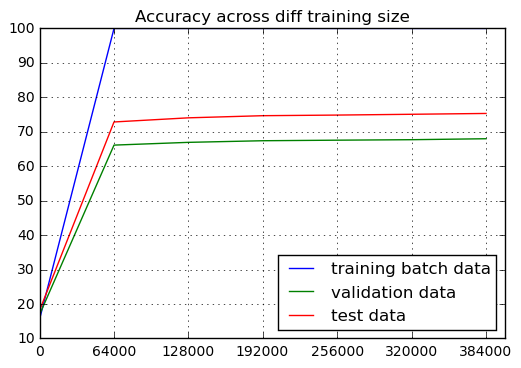

In [75]:
#plot_accuracy(accuracy_all)
#print(accuracy_all_small)
plot_accuracy(accuracy_all_small)

**Conclusion : ** We observed that, when few train datasets (i.e 500) are provided, then the Minibatch accuracy is 100% across each steps, while the validation accuracy is 78.5%. This indicates the extreme case of overfitting, where our model is completely able to predict across training dataset with 100% correctness, however when faced with new data as in the validation set,  the performance significantly drops. This may be explained by the fact that  the only training set is ['256-384', '128-256', '0-128'] index data of the all available.  

Compare this to our earlier cases, where we used the full dataset and our training samples were 3000 different training examples, the minibatch accuracy was never vastly different to the validation accurayc and never greater than 89%, which meant that the model generated from the training was never overfitting. And that the train model also performed with fairly similar performance across train and validation set meant that the model was generic enough to work even for the unseen data.



---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

NN with Dropout, now regularisation
--------------------------------------------

In [ ]:

batch_size = 128
num_hidden = 1024
beta = 0.01

graph = tf.Graph()
with graph.as_default():

  # Input data. Unlike in earlier gradient descent, now we can take the whole data.
  # With gradient descent, we could not process all the input data and we had poor accuracy
  # For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  weights_for_hidden = tf.Variable(tf.truncated_normal([ image_size * image_size , num_hidden]))
  biases_for_hidden = tf.Variable(tf.zeros([num_hidden]))
  weights = tf.Variable(
    tf.truncated_normal([num_hidden, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_for_hidden ) + biases_for_hidden)
  hidden_valid_dataset = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_for_hidden) + biases_for_hidden)
  hidden_test_dataset = tf.nn.relu(tf.matmul(tf_test_dataset, weights_for_hidden) + biases_for_hidden)
  #logits = tf.matmul(tf_train_dataset, weights) + biases
  
  logits = tf.matmul(hidden1, weights) + biases
  # loss without regularisation
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  ## loss with regularisation
  regularisation_term = tf.nn.l2_loss(weights_for_hidden) + tf.nn.l2_loss(weights)
  loss = tf.reduce_mean( loss + beta * regularisation_term)

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)  

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(hidden_test_dataset, weights) + biases)
print('Deep Neural Network with 1 Hidden layer with 1024 hidden nodes initialisation complete', datetime.datetime.now())




---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
